# 1. Imports

In [1]:
from pathlib import Path
import json
import numpy as np

import torch
import matplotlib.pyplot as plt
import cmocean
from scipy.ndimage import rotate
from tqdm import tqdm

color_map = cmocean.cm.ice

from applefy.utils.file_handling import load_adi_data

from s4hci.utils.data_handling import read_s4hci_root_dir

# 2. Load the dataset

In [2]:
dataset_name = "HD22049_303_199_C-0065_C_"
root_dir = Path(read_s4hci_root_dir())
json_file = root_dir / Path("30_data/" + dataset_name + ".json")

Data in the S4HCI_ROOT_DIR found. Location: /fast/mbonse/s4


In [3]:
with open(json_file) as f:
    parameter_config = json.load(f)

dit_psf_template = float(parameter_config["dit_psf"])
dit_science = float(parameter_config["dit_science"])
fwhm = float(parameter_config["fwhm"])
scaling_factor = float(parameter_config["nd_scaling"])
lambda_reg = float(parameter_config["lambda_reg"])
svd_approx = int(parameter_config["svd_approx"])
pixel_scale = 0.02718

In [4]:
dataset_file = root_dir / Path("30_data/" + dataset_name + ".hdf5")

In [5]:
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

In [6]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

# 3. Plot the PCA components

In [7]:
# 1.) Convert images to torch tensor
im_shape = science_data.shape
images_torch = torch.from_numpy(science_data)

# 2.) remove the mean as needed for PCA
images_torch = images_torch - images_torch.mean(dim=0)

# 3.) reshape images to fit for PCA
images_torch = images_torch.view(im_shape[0], im_shape[1] * im_shape[2])

# 4.) compute PCA basis
_, _, V = torch.svd_lowrank(images_torch, niter=1, q=2000)

In [8]:
pca_number = 300
components = V[:, :pca_number].reshape(91, 91, pca_number)

In [9]:
# Create a subfolder for the plots
Path("./final_plots/illustration_plots").mkdir(parents=True, exist_ok=True)

In [10]:
# Plot the first 4 PCA components without any title as separate pdfs

# find a common color range
vmin = torch.min(components[:, :, :4]) * 0.7
vmax = torch.max(components[:, :, :4]) * 0.7

for i in range(4):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(components[:, :, i],
              cmap="magma",
              vmin=vmin, 
              vmax=vmax)
    ax.axis("off")
    
    plt.savefig(f"./final_plots/illustration_plots/x1_pca_component_{i}.pdf", bbox_inches='tight')
    plt.close()

# 4. Plot the unsaturated PSF

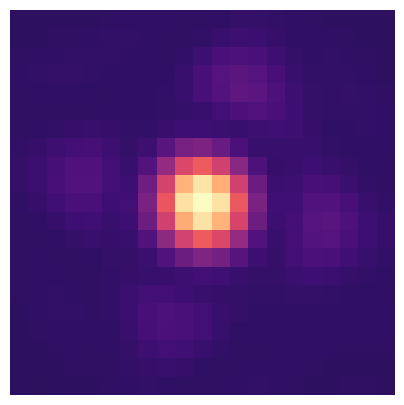

In [34]:
# plot the unsaturated PSF
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# make the image a bit brighter by setting vmin and vmax
ax.imshow(psf_template, cmap="magma", 
          vmin=-2000, vmax=10000)
ax.axis("off")

# set the background color to transparent
fig.patch.set_alpha(0.0)

plt.savefig(f"./final_plots/illustration_plots/x2_psf_template.pdf", bbox_inches='tight')

# 5. Plot examples of time series in S4

In [12]:
# subtract the temporal mean from the science data
# create a copy of the data
science_mean_sub = science_data - science_data.mean(axis=0)

In [13]:
# Derotate all science images
derotated_science = np.zeros_like(science_mean_sub)

for i in tqdm(range(science_mean_sub.shape[0])):
    derotated_science[i] = rotate(
        science_mean_sub[i], 
        -np.rad2deg(angles[i]),
        reshape=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11593/11593 [00:06<00:00, 1666.21it/s]


In [24]:
# select 4 positions
positions = np.array([[30, 30], [70, 45], [50, 50], [30, 70]])

# get the time series for the selected positions
time_series = derotated_science[:5000, positions[:, 0], positions[:, 1]]
time_series = time_series.T

In [25]:
# smooth the time series with a gaussian filter
from scipy.ndimage import gaussian_filter1d
smoothed_time_series = gaussian_filter1d(time_series, 100, axis=1)

# normalize the time series such that each series in the range [0, 1]
smoothed_time_series = (smoothed_time_series.T - smoothed_time_series.min(axis=1)) / (smoothed_time_series.max(axis=1) - smoothed_time_series.min(axis=1))
smoothed_time_series = smoothed_time_series.T

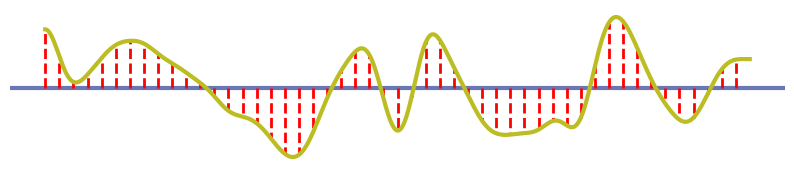

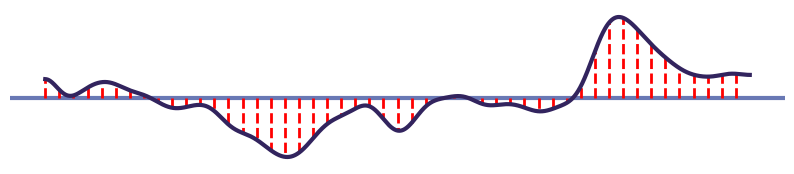

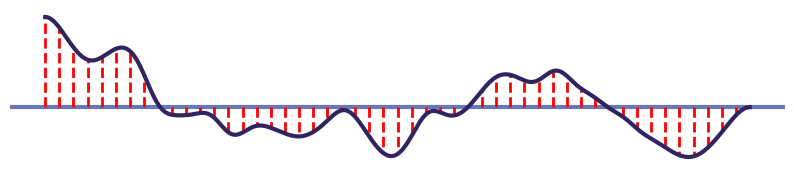

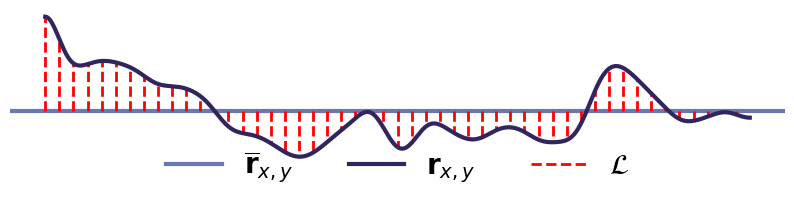

In [35]:
# define the colors for the time series (colorblind friendly) not red, blue, orange
colors = ["#bcbd22", "#32245E",  "#32245E",  "#32245E"]

# plot the time series in 4 separate plots
for i in range(4):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    # plot the mean as a horizontal line
    ax.axhline(smoothed_time_series[i].mean(), 
               color="#6978b4", 
               linestyle="-", 
               label=r"$\mathbf{\overline{r}}_{x, y}$", lw=3)
    
    
    
        
    # plot the time series    
    ax.plot(smoothed_time_series[i],
            color=colors[i],
            zorder=10,
            label=r"$\mathbf{r}_{x, y}$", lw=3)
    
    # plot read vertical lines between the time series and the mean every 1000 frames
    for j in range(0, 5000, 100):
        ax.plot([j, j], 
                [smoothed_time_series[i].mean(), 
                 smoothed_time_series[i][j]],
                label=r"$\mathcal{L}$",
                color="red", linestyle="--", lw=2)
    
    # Turn off the axis and grid
    ax.axis("off")
    ax.grid(False)
    
    # for the last plot add a legend
    # add the legend below outside the plot
    # remove duplicate labels
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if i == 3:
        ax.legend(
            by_label.values(),
            by_label.keys(), 
            fontsize=20,
            bbox_to_anchor=(0.5, -0.3),
            loc="lower center", ncol=3, frameon=False)
    
    # set the background color to transparent
    fig.patch.set_alpha(0.0)
    
    # save the plot
    plt.savefig(f"./final_plots/illustration_plots/x2_time_series_{i}.pdf", 
                bbox_inches='tight')